In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

data_base_path = os.getenv("DATA_BASE_PATH", "./data")  # default or raise with message
if not data_base_path:
    raise RuntimeError(
        "DATA_BASE_PATH env-var is required – point it to your dataset root."
    )

### Intro
- For this reasoning demo we will use the financeBench documents to customize a model on SEC fillings

In [8]:
from datasets import load_dataset, concatenate_datasets
from openai import OpenAI

endpoint = f"http://localhost:8000/v1"
openai_api_key = "EMPTY"
openai_api_base = endpoint

client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)
teacher_model = client.models.list().data[0].id

[14:57:13] INFO     HTTP Request: GET http://localhost:8000/v1/models "HTTP/1.1 200 OK"             ]8;id=613503;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=722975;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

### Do Document Processing on Finance Bench Documents
- git clone https://github.com/patronus-ai/financebench.git to get pdfs
- We will use docling and its hybrid chunker to parse and convert these pdfs into chunks

In [ ]:
data_dir = 'document_collection/ibm-annual-report'
!OMP_NUM_THREADS=32 mamba run -n docling python ../scripts/docparser_v2.py --input-dir financebench/finance_documents/ --output-dir financebench/finance_documents/ -c docling_v2_config.yaml

In [1]:
import yaml
config = {
    "pipeline": {
        "ocr": {
            "enabled": True,      # Enable/disable OCR processing
            "languages": ["es"],  # List of language codes (e.g., eng, fra, deu)
        },
        "tables": {
            "enabled": True,        # Enable/disable table detection
            "cell_matching": True,  # Enable/disable cell matching in tables
        },
        "performance": {
            "threads": 32,          # Number of processing threads
            "device": "auto"       # Device selection (auto, cpu, gpu)
        }
    },
    "export": {
        "formats": {
            "json": False,      # Deep Search JSON format
            "text": False,      # Plain text
            "markdown": True,  # Markdown with structure
            "html": True,     # HTML with styling
            "doctags": False   # Document tokens
        }
    }
}

with open('docling_v2_config.yaml', 'w') as f:
    yaml.dump(config, f)


In [ ]:
import os
from datasets import load_dataset

ds = load_dataset("PatronusAI/financebench", split="train")
ds.filter(lambda x: '3M' in x['doc_name'])
all_docs = ds['doc_name']
all_pdfs = [e.replace(".pdf", "") for e in os.listdir("financebench/pdfs/")]
all_pdfs = [e for e in all_pdfs if e in all_docs]
import shutil
# Copy the pdfs to the financebench/pdfs_filtered/ directory
os.makedirs("financebench/pdfs_filtered/", exist_ok=True)
for pdf in all_pdfs:
    shutil.copy(f"financebench/pdfs/{pdf}.pdf", f"financebench/pdfs_filtered/{pdf}.pdf")

In [98]:
# We can reuse ICLs from the previous quality data
icls = [{
  "icl_document": """**Investor Briefing Summary: 3M 2022 Financial Highlights**  

**Total Company Performance (YoY Change)**  
- **Revenue**: $34.229B (↓3.2% from $35.355B in 2021)  
- **Operating Income**: $6.539B (↓11.3% from $7.369B in 2021)  
- **Operating Margin**: 19.1% (↓1.7% from 20.8% in 2021)  

**Segment Performance (YoY Changes)**  
1. **Safety and Industrial**  
   - Revenue: $11.604B (↓3.2%)  
   - Operating Income: $1.199B (↓51.4%)  
   *Sharp decline due to litigation costs (PFAS-related) and productivity headwinds.*  

2. **Transportation and Electronics**  
   - Revenue: $8.902B (↓3.9%)  
   - Operating Income: $1.012B (↓46.2%)  
   *Impacted by divestitures and currency translation.*  

3. **Health Care**  
   - Revenue: $8.421B (↓2.0%)  
   - Operating Income: $1.815B (↓10.9%)  
   *Most resilient segment, with organic growth offset by currency.*  

4. **Consumer**  
   - Revenue: $5.298B (↓3.9%)  
   - Operating Income: $994M (↓14.4%)  
   *Organic sales declined 0.9% amid pricing and logistics challenges.*  

5. **Corporate and Unallocated**  
   - Operating Income: $1.519B (vs. $(176)M in 2021)  
   *Driven by divestiture gains and reduced unallocated costs.*""",

  "icl_query_1": "How did 3M’s overall financial performance change in 2022 compared to 2021?",
  "icl_response_1": "In 2022, 3M’s total revenue declined by 3.2% year-over-year, falling from $35.355 billion in 2021 to $34.229 billion. Operating income also decreased by 11.3%, dropping from $7.369 billion to $6.539 billion, while the operating margin declined from 20.8% to 19.1%.",
  "icl_query_2": "What factors contributed to the significant decline in operating income in the Safety and Industrial segment?",
  "icl_response_2": "The Safety and Industrial segment saw a 51.4% drop in operating income, down to $1.199 billion. This sharp decline was primarily attributed to litigation costs related to PFAS and productivity headwinds.",

  "icl_query_3": "Which segment showed the most resilience in 3M’s 2022 performance, and what challenges did it face?",
  "icl_response_3": "The Health Care segment was the most resilient in 2022, experiencing the smallest year-over-year revenue decline of 2.0% and a 10.9% drop in operating income. Its organic growth helped offset currency-related headwinds.",
}
]


In [ ]:
import glob
from utils import chunk_document
from datasets import Dataset

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nvidia/Llama-3.1-Nemotron-Nano-8B-v1")


def break_large_chunks(text, max_chunk_size=7000):
    chunks = chunk_document([text], server_ctx_size=50000, chunk_word_count=max_chunk_size)
    return chunks

all_mds = glob.glob("financebench/finance_documents/*.md")
finance_bench_ds = []
for md in all_mds:
    print(md)
    with open(md, "r") as f:
        text = f.read()
    chunks = chunk_document([text], server_ctx_size=40000, chunk_word_count=7000)
    new_chunks = []
    for chunk in chunks:
        if len(tokenizer.encode(chunk)) > 7000:
            new_chunks.extend(break_large_chunks(chunk, 5000))
        else:
            new_chunks.append(chunk)
    document_outline = md.split("/")[-1].replace(".md", "").replace("_", " ")
    finance_bench_ds.extend([{'document_outline': document_outline, 'document': chunk, **icls[0]} for chunk in new_chunks])

finance_bench_ds = Dataset.from_list(finance_bench_ds)
finance_bench_ds.to_json("3M_SEC_filings_seed_data.jsonl", orient="records", lines=True)

### Analyze Chunks

- Our aim is to get similar chunk size distribution (in terms of tokens) as Quality dataset. 
- We are using the markdown chunker that uses words to approximate chunk size in tokens

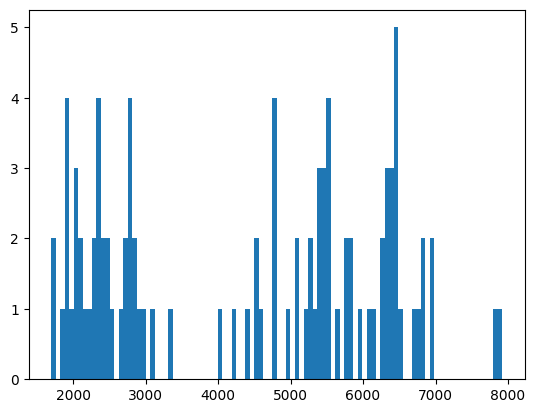

In [62]:
finance_bench_ds = finance_bench_ds.map(lambda x: {"token_size": len(tokenizer.encode(x['document']))}, batched=False)
# Plot the distribution of SEC filings data for 3M
import matplotlib.pyplot as plt
plt.hist(finance_bench_ds['token_size'], bins=100)
plt.show()

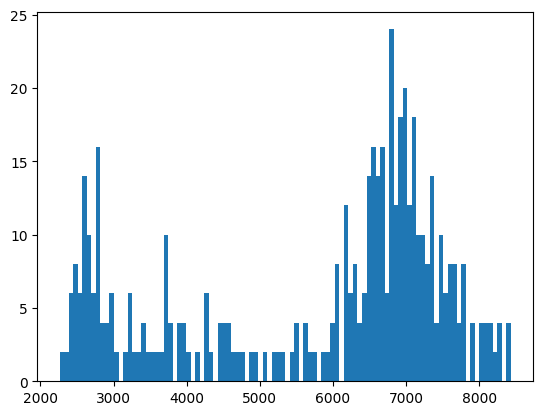

In [38]:
quality_seed = load_dataset("json", data_files="seed_data.jsonl", split="train")
quality_seed = quality_seed.map(lambda x: {"token_size": len(tokenizer.encode(x['document']))}, batched=False)
# Plot the distribution of the token size of Quality Data
import matplotlib.pyplot as plt
plt.hist(quality_seed['token_size'], bins=100)
plt.show()

## SDG Generation

### Changes to Prompt
- Once our teacher model is hosted and visible through the Openai client we can start setting up the flow
- Coming from previous notebooks we will make 1 small change to the summarization prompt. We will add this:

    `- Include as much of the document as possible to create a comprehensive summary`

    `- If there are tables include all the data of the table in the summary`

- This is required to ensure finance documents, that have densely packed information, does not get removed when summarizing

In [14]:
from sdg_hub.flow import Flow
from sdg_hub.pipeline import Pipeline
from sdg_hub.sdg import SDG
from transformers import AutoTokenizer
import utils
from datasets import load_dataset
import prompts.prompts
import blocks.blocks

ds = load_dataset('json', data_files="3M_SEC_filings_seed_data.jsonl", split="train")
knowledge_agentic_pipeline = "flows/synth_knowledge_reasoning_nemotron_super_49b_summary_diversity.yaml"
flow_cfg = Flow(client).get_flow_from_file(knowledge_agentic_pipeline)
sdg = SDG(
    [Pipeline(flow_cfg)],
    num_workers=1,
    batch_size=1,
    save_freq=1000,
)

In [34]:
from datasets import Dataset
ds_new = Dataset.from_list([{
    "document": """## PERFORMANCE BY BUSINESS SEG MENT

For a detailed discussion of the markets served and types of products offered by 3M's business segments, see Item 1, Business Segments. Financial information and other disclosures are provided in the Notes to the Consolidated Financial Statements. Effective in the first quarter of 2018, as part of 3M's continuing effort to improve the alignment of its businesses around markets and customers, the Company made the following changes:

## Consolidation of customer account activity within international countries - expanding dual credit reporting

The Company consolidated its customer account activity in each country into centralized sales districts for certain countries that make up approximately 70 percent of 3M's 2017 international net sales. Expansion of these initiatives, which previously had been deployed only in the U.S., reduces the complexity for customers when interacting with multiple 3M businesses. 3M business segment reporting measures include dual credit to business segments for certain sales and related operating income. This dual credit is based on which business segment provides customer account activity with respect to a particular product sold in a specific country. The expansion of alignment of customer accounts within additional countries increased the attribution of dual credit across 3M's business segments. Additionally, certain sales and operating income results for electronic bonding product lines that were previously equally divided between the Electronics and Energy business segment and the Industrial business segment are now reported similarly to dual credit.""",
    "document_outline": "3M SEC Filings Form 10-K 2018",
    "icl_document": ds[0]['icl_document'],
    "icl_query_1": ds[0]['icl_query_1'],
    "icl_response_1": ds[0]['icl_response_1'],
    "icl_query_2": ds[0]['icl_query_2'],
    "icl_response_2": ds[0]['icl_response_2'],
    "icl_query_3": ds[0]['icl_query_3'],
    "icl_response_3": ds[0]['icl_response_3']
}])

In [35]:
generated_data = sdg.generate(ds_new, checkpoint_dir="Tmp")

[15:12:57] INFO     No existing checkpoints found in Tmp, generating from scratch                        ]8;id=899497;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py\sdg.py]8;;\:]8;id=588678;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py#107\107]8;;\

           INFO     Splitting the dataset into smaller batches                                           ]8;id=69369;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py\sdg.py]8;;\:]8;id=991517;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py#123\123]8;;\

100%|██████████| 1/1 [00:00<00:00, 27413.75it/s]


           INFO     Generating dataset with 1 splits, batch size 1, and 1 workers                        ]8;id=499151;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py\sdg.py]8;;\:]8;id=545458;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py#129\129]8;;\

           INFO     Processing split 0                                                                    ]8;id=342336;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py\sdg.py]8;;\:]8;id=306059;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py#75\75]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

[15:13:16] INFO     HTTP Request: POST http://localhost:8000/v1/completions "HTTP/1.1 200 OK"       ]8;id=570550;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=618084;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

Map: 100%|██████████| 20/20 [00:00<00:00, 6003.44 examples/s]


[15:13:45] INFO     HTTP Request: POST http://localhost:8000/v1/completions "HTTP/1.1 200 OK"       ]8;id=42578;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=691450;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

Map: 100%|██████████| 20/20 [00:00<00:00, 4306.27 examples/s]


[15:14:11] INFO     HTTP Request: POST http://localhost:8000/v1/completions "HTTP/1.1 200 OK"       ]8;id=973945;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=689824;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

Map: 100%|██████████| 80/80 [00:00<00:00, 10023.13 examples/s]


[15:14:33] INFO     HTTP Request: POST http://localhost:8000/v1/completions "HTTP/1.1 200 OK"       ]8;id=211188;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=940250;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

Map: 100%|██████████| 80/80 [00:00<00:00, 9205.10 examples/s]


[15:15:05] INFO     HTTP Request: POST http://localhost:8000/v1/completions "HTTP/1.1 200 OK"       ]8;id=768170;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=755231;file:///home/lab/.conda/envs/research_sdg/lib/python3.10/site-packages/httpx/_client.py#1025\1025]8;;\

           INFO     Finished future processing split 0                                                   ]8;id=404167;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py\sdg.py]8;;\:]8;id=54051;file:///workspace/home/lab/abhi/sdg_hub/src/sdg_hub/sdg.py#149\149]8;;\
                                                                                                                   
                                                                                                                   

100%|██████████| 1/1 [02:07<00:00, 127.53s/it]


In [51]:
idx = 3
generated_data_ = generated_data.filter(lambda x: len(x['document']) < 1800)
print("### Document")
print(generated_data_['raw_document'][idx])
print("### Generated Summary Instruction")
print(generated_data_['summary_instruction'][idx])
print("### Generated Document Summary")
print(generated_data_['document'][idx])

Filter:   0%|          | 0/80 [00:00<?, ? examples/s]

Filter: 100%|██████████| 80/80 [00:00<00:00, 21751.87 examples/s]

### Document
## PERFORMANCE BY BUSINESS SEG MENT

For a detailed discussion of the markets served and types of products offered by 3M's business segments, see Item 1, Business Segments. Financial information and other disclosures are provided in the Notes to the Consolidated Financial Statements. Effective in the first quarter of 2018, as part of 3M's continuing effort to improve the alignment of its businesses around markets and customers, the Company made the following changes:

## Consolidation of customer account activity within international countries - expanding dual credit reporting

The Company consolidated its customer account activity in each country into centralized sales districts for certain countries that make up approximately 70 percent of 3M's 2017 international net sales. Expansion of these initiatives, which previously had been deployed only in the U.S., reduces the complexity for customers when interacting with multiple 3M businesses. 3M business segment reporting me

### Generated Summary Instruction
```text
**Highlight Tax Strategy Efficiency**: Analyze how 3M’s tax planning (e.g., Food Safety divestiture, GILTI/FDII) reduced its effective tax rate, with numerical examples.
```
### Generated Document Summary
```text
**Comprehensive Summary of 3M’s 2022 Form 10-K Filing with Emphasis on Tax Strategy Efficiency**

---

### **1. Effective Tax Rate Reconciliation & Tax Strategy Efficiency**

| **Factor**               | **2022** | **2021** | **2020** |  
|--------------------------|---------|---------|---------|  
| Statutory U.S. Tax Rate  | 21.0%   | 21.0%   | 21.0%   |  
| **Food Safety Divestiture** | **-8.4%** | -       | -       | *Key driver of 2022 tax rate reduction*  
| State Income Taxes       | -       | 0.9%   | 1.2%   |  
| International Income Taxes| -0.4%  | -1.2%  | -1.2%  |  
| **GILTI**                | 0.7%   | 0.7%   | 0.8%   |  
| **FDII**                 | -2.3%  | -3.1%  | -1.8%  |  
| U.S. R&D Credit          | -1.0%  | -0.7%  | -1.0%  |  
| Reserves for Tax Contingencies| -    | 0.6%   | 0.5%   |  
| Employee Share-Based Payments| -0.2% | -0.6%  | -0.5%  |  
| All Other                 | 0.2%   | 0.2%   | 0.7%   |  
| **Effective Tax Rate**   | **9.6%** | **17.8%**| **19.7%**|  

- **Tax Rate Reduction**:  
  - **2022 vs. 2021**: 8.2% decrease primarily due to **Food Safety divestiture** (saved 8.4% of tax rate).  
  - **2021 vs. 2020**: 1.9% decrease attributed to geographical income mix and favorable TCJA adjustments.  

- **GILTI/FDII Impact**:  
  - GILTI increased tax rate by 0.7% in 2022 (vs. 0.8% in 2020).  
  - FDII reduced tax rate by 2.3% in 2022 (vs. 3.1% in 2021), reflecting efficient intangible income planning.  

---

### **2. TCJA Provisions & Transition Tax**

- **Transition Tax (TCJA)**: $380M (2022) and $508M (2021) in long-term income taxes payable over 8 years.  
- **Short-Term Transition Tax**: $126M (2022) and $68M (2021).  

---

### **3. Uncertain Tax Positions (UTB)**

| **(Millions)**         | **2022** | **2021** | **2020** |  
|-------------------------|---------|---------|---------|  
| Gross UTB Balance (Jan 1)| 1,071   | 1,113   | 1,167   |  
| Additions (Current Year)| 115    | 91      | 74      |  
| Additions (Prior Years) | 36    | 22      | 106     |  
| Reductions (Prior Years)| -138   | -60     | -173    |  
| Settlements              | -118   | -57     | -8      |  
| Statute of Limitations   | -39    | -38     | -53     |  
| **Gross UTB (Dec 31)**  | **927** | **1,071**| **1,113**|  
| **Net UTB (Impact on ETR)**| **965** | **1,112**| **1,145**|  

- **Net UTB**: $965M (2022) could affect ETR if recognized.  
- **Interest/Penalties**: $116M accrued in 2022 (vs. $140M in 2021).  

---

### **4. Foreign Tax Benefits & Undistributed Earnings**

- **Tax-Exempt/Subsidized Income**:  
  - China (2022), Switzerland (2026), Brazil (2029), Singapore (2032) generated $170M (30¢/share) in 2022 tax benefits.  
- **Undistributed Foreign Earnings**: $16.0B (2022), with $8.0B no longer permanently reinvested (immaterial repatriation tax cost).  

---

### **5. Marketable Securities (2022/2021)**

| **(Millions)**         | **2022** | **2021** |  
|-------------------------|---------|---------|  
| Commercial Paper         | 213    | 109     |  
| Certificates of Deposit  | 21     | 14     |  
| U.S. Treasury Securities | -      | 75     |  
| **Current Securities**   | **238** | **201** |  
| Non-Current Securities   | 23     | 27     |  
| **Total**                | **261** | **228** |  

---

### **6. Long-Term Debt (Select Entries, 2022/2021)**

| **Description**                  | **2022 Carrying Value** | **2021 Carrying Value** | **Effective Interest Rate** |  
|-----------------------------------|------------------------|------------------------|---------------------------|  
| USD Fixed (2023, $500M)          | $500                  | $499                  | 1.86%                    |  
| EUR Fixed (2023, €600M)          | $679                  | $679                  | 1.14%                    |  
| USD Floating (2024, $300M)      | $300                  | $300                  | 4.81%                    |  
| **Total Long-Term Debt**         | **$15,939**            | **$17,347**            |                           |  

---

### **Key Tax Strategy Takeaways**

1. **Food Safety Divestiture**: Saved 8.4% of tax rate in 2022 via tax-efficient structuring.  
2. **GILTI/FDII Optimization**: FDII provided greater tax savings than GILTI costs (e.g., 2022: -2.3% vs. +0.7%).  
3. **Foreign Subsidiary Planning**: Leveraged low-tax jurisdictions (e.g., China, Switzerland) for $170M in annual benefits.  
4. **Repatriation Strategy**: $8.0B in non-permanently reinvested earnings with minimal tax liability.  

---

### **Full Tables for Reference**

#### **Reconciliation of Effective Tax Rate (Detailed)**

| Factor                                  | 2022 | 2021 | 2020 |  
|-----------------------------------------|------|------|------|  
| Statutory U.S. Tax Rate                 |21.0%|21.0%|21.0%|  
| **Food Safety Divestiture**             |-8.4%| -   | -   |  
| State Income Taxes                      |-    |0.9%|1.2% |  
| International Income Taxes              |-0.4%|-1.2%|-1.2%|  
| **GILTI**                              |0.7%|0.7%|0.8% |  
| **FDII**                               |-2.3%|-3.1%|-1.8%|  
| U.S. R&D Credit                         |-1.0%|-0.7%|-1.0%|  
| Reserves for Tax Contingencies          |-    |0.6%|0.5% |  
| Employee Share-Based Payments           |-0.2%|-0.6%|-0.5%|  
| All Other                               |0.2%|0.2%|0.7% |  
| **Effective Tax Rate**                  |9.6%|17.8%|19.7%|  

#### **Gross Unrecognized Tax Benefits**

| **(Millions)**         | **2022** | **2021** | **2020** |  
|-------------------------|---------|---------|---------|  
| Gross UTB Balance (Jan 1)| 1,071   | 1,113   | 1,167   |  
| Additions (Current Year)| 115    | 91      | 74      |  
| Additions (Prior Years) | 36    | 22      | 106     |  
| Reductions (Prior Years)| -138   | -60     | -173    |  
| Settlements              | -118   | -57     | -8      |  
| Statute of Limitations   | -39    | -38     | -53     |  
| **Gross UTB (Dec 31)**  | **927** | **1,071**| **1,113**|  

#### **Marketable Securities Maturity**

| **(Millions)**         | **2022** |  
|-------------------------|---------|  
| Due in one year or less | 238    |  
| Due after one year      | 15     |  
| Due after five years    | 8      |  
| **Total**               | **261** |  

#### **Long-Term Debt (Full Table Omitted for Brevity)**

*Refer to original filing for detailed debt schedule.*  

---

### **Numerical Examples of Tax Efficiency**

1. **Food Safety Divestiture Impact**: Reduced 2022 ETR by 8.4% (from 21.0% to 9.6%).  
2. **FDII Savings**: Saved 2.3% of tax rate in 2022 (vs. 3.1% in 2021).  
3. **GILTI Cost**: Added 0.7% to tax rate in 2022 (consistent across years).  
4. **Foreign Tax Credits**: $170M benefit in 2022 (30¢/share).  

--- 

**Summary Conclusion**:  
3M’s tax strategy leveraged divestitures, TCJA provisions (GILTI/FDII), and foreign jurisdiction planning to achieve a record-low 9.6% ETR in 2022. The Food Safety divestiture alone saved 8.4%, while FDII outperformed GILTI in tax savings. Foreign subsidiaries contributed $170M in annual benefits, and undistributed earnings pose minimal repatriation risk.  

---

**All Tables Included as Requested**  

Let me know if further clarification is needed!
```

In [49]:
idx = 2
print("### Question")
print(generated_data_[idx]['question'])
print("### Generated Answer")
print(generated_data_[idx]['response'])

### Question
Explain the dual credit reporting mechanism introduced by 3M in 2018 and how it affected the Electronic Bonding Product Lines.

### Generated Answer
<think>
Okay, let's tackle this question. The user is asking about the dual credit reporting mechanism introduced by 3M in 2018 and its impact on the Electronic Bonding Product Lines.

First, I need to recall the document provided. The key points from the document mention that 3M made organizational changes in customer account management. Specifically, they expanded the dual credit reporting mechanism. 

The dual credit mechanism assigns credit (for sales and operating income) to business segments based on which segment manages the customer account activity for a product in a specific country. Before this change, Electronic Bonding Product Lines were split equally between the Electronics and Energy and Industrial segments. Now, with the dual credit method, the reporting is aligned with the country-based account responsibility.

### Question
```text
What was the primary factor contributing to the 8.2% decrease in 3M’s effective tax rate from 2021 to 2022?
```
### Generated Answer
```text
<think>
Okay, let's tackle this question. The user is asking for the primary factor that caused the 8.2% decrease in 3M's effective tax rate from 2021 to 2022.

First, I need to look through the provided document to find the relevant information. The document is a comprehensive summary of 3M's 2022 Form 10-K filing, focusing on tax strategy efficiency. 

Scanning through the sections, the first part under "1. Effective Tax Rate Reconciliation & Tax Strategy Efficiency" has a table showing the effective tax rates for 2022, 2021, and 2020. The effective tax rate dropped from 17.8% in 2021 to 9.6% in 2022, which is an 8.2% decrease. 

Below the table, there's a bullet point under "Tax Rate Reduction" that explains the 2022 vs. 2021 decrease. It states: "- **2022 vs. 2021**: 8.2% decrease primarily due to **Food Safety divestiture** (saved 8.4% of tax rate)." 

Additionally, in the "Key Tax Strategy Takeaways" section, point 1 mentions the Food Safety Divestiture saving 8.4% of the tax rate in 2022 via tax-efficient structuring. The numerical examples also highlight that the Food Safety Divestiture reduced the ETR by 8.4%, which aligns with the primary factor.

Other factors in the reconciliation table, like FDII and GILTI, have smaller impacts. For instance, FDII reduced the tax rate by 2.3% in 2022, but that's not the primary factor here. The main driver is clearly the Food Safety divestiture as stated in multiple parts of the document.

So the answer should directly reference the Food Safety divestiture as the primary factor causing the 8.2% decrease. Making sure to mention the 8.4% savings from the divestiture and that it's the primary reason as per the document.
</think>


The primary factor contributing to the 8.2% decrease in 3M’s effective tax rate from 2021 to 2022 was the **Food Safety divestiture**, which saved 8.4% of the tax rate through tax-efficient structuring. This divestiture was explicitly cited as the key driver of the reduced effective tax rate from 17.8% in 2021 to 9.6% in 2022.
```

### Analyze Generated data

Map (num_proc=16): 100%|██████████| 8573/8573 [00:01<00:00, 7131.43 examples/s] 


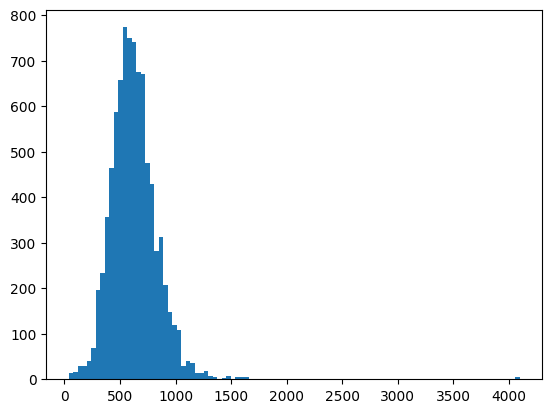

In [71]:
# Data generated from previous notebook
from transformers import AutoTokenizer
from datasets import load_dataset

# Load tokenizer for pre-training formatting
tokenizer = AutoTokenizer.from_pretrained("nvidia/Llama-3.1-Nemotron-Nano-8B-v1")
threeM_reasoning_ds = load_dataset("json", data_dir=f"{data_base_path}/3m_sec_filings/synth_knowledge_reasoning_nemotron_super_49b_summary_diversity/", split="train")
threeM_reasoning_ds = threeM_reasoning_ds.map(lambda x: {'token_size': len(tokenizer.encode(x['document']))}, batched=False, num_proc=16)
# Plot the distribution of SEC filings data for 3M
import matplotlib.pyplot as plt
plt.hist(threeM_reasoning_ds['token_size'], bins=100)
plt.show()

Generating train split: 8110 examples [00:01, 6133.65 examples/s]
Map (num_proc=16): 100%|██████████| 8110/8110 [00:01<00:00, 4576.26 examples/s]


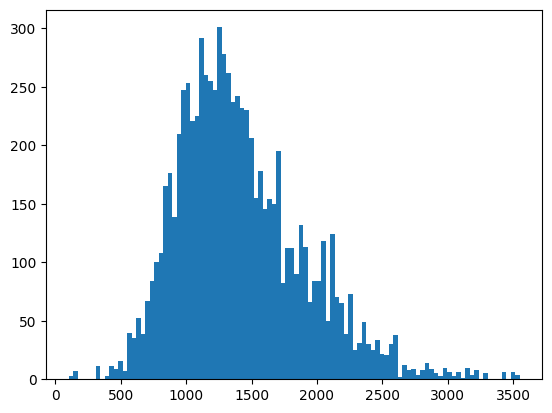

In [4]:
# With changes to prompt
from transformers import AutoTokenizer
from datasets import load_dataset
data_base_path = os.environ["DATA_BASE_PATH"]
# Load tokenizer for pre-training formatting
tokenizer = AutoTokenizer.from_pretrained("nvidia/Llama-3.1-Nemotron-Nano-8B-v1")
threeM_reasoning_ds = load_dataset("json", data_dir=f"{data_base_path}/3m_sec_filings/synth_knowledge_reasoning_nemotron_super_49b_summary_diversity_detailed/", split="train")
threeM_reasoning_ds = threeM_reasoning_ds.map(lambda x: {'token_size': len(tokenizer.encode(x['document']))}, batched=False, num_proc=16)
# Plot the distribution of SEC filings data for 3M
import matplotlib.pyplot as plt
plt.hist(threeM_reasoning_ds['token_size'], bins=100)
plt.show()

## Create training mix

In [ ]:
from utils import create_training_mix
from transformers import AutoTokenizer
from datasets import load_dataset, concatenate_datasets
 
def extract_think(x):
    if 'messages' in x:
        if '<think>' in x['messages'][2]['content'] and '</think>' in x['messages'][2]['content']:
            return {'think' : x['messages'][2]['content'][x['messages'][2]['content'].find('<think>')+len('<think>'):x['messages'][2]['content'].find('</think>')]}
    elif '<think>' in x['response'] and '</think>' in x['response']:
        return {'think' : x['response'][x['response'].find('<think>')+len('<think>'):x['response'].find('</think>')]}
    return {'think' : ''}


data_base_path = os.environ["DATA_BASE_PATH"]
# Load tokenizer for pre-training formatting
tokenizer = AutoTokenizer.from_pretrained("nvidia/Llama-3.1-Nemotron-Nano-8B-v1")


# Load reasoning dataset from nemotron super 49b
threeM_reasoning_ds = load_dataset("json", data_dir=f"{data_base_path}/3m_sec_filings/synth_knowledge_reasoning_nemotron_super_49b_rewrite_with_diversity/", split="train")
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: '[QUESTION]' not in x['response'])
# Filter out responses that don't have a single think block
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: x['response'].count('<think>') == 1 and x['response'].count('</think>') == 1)
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: x['question'].count('<think>') == 0 and x['question'].count('</think>') == 0)
# Filter out summaries that are too short
threeM_reasoning_ds = threeM_reasoning_ds.map(lambda x: {'token_size': len(tokenizer.encode(x['document']))}, batched=False, num_proc=16)
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: x['token_size'] > 300).remove_columns(['token_size'])
print(threeM_reasoning_ds)
# Create reasoning training mix
threeM_reasoning_ds = threeM_reasoning_ds.add_column('domain', ['SEC Filings'] * len(threeM_reasoning_ds))
threeM_reasoning_ds = create_training_mix(threeM_reasoning_ds, tokenizer, 'on', create_summary=False)
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: '<think>' in x['messages'][2]['content'] and '</think>' in x['messages'][2]['content'])
threeM_reasoning_ds = threeM_reasoning_ds.map(extract_think, batched=False, num_proc=16)
threeM_reasoning_ds = threeM_reasoning_ds.filter(lambda x: x['think'].strip()).remove_columns(['think'])


# Load non-reasoning dataset from nemotron super 49b
threeM_non_reasoning_ds = load_dataset("json", data_dir=f"{data_base_path}/3m_sec_filings/synth_knowledge_reasoning_nemotron_super_49b/", split="train")
threeM_non_reasoning_ds = threeM_non_reasoning_ds.add_column('domain', ['SEC Filings'] * len(threeM_non_reasoning_ds))
threeM_non_reasoning_ds = threeM_non_reasoning_ds.filter(lambda x: x['score'] == '2' and x['judgment'] == 'YES')
print(threeM_non_reasoning_ds)

# Create non-reasoning training mix
threeM_non_reasoning_ds = create_training_mix(threeM_non_reasoning_ds, tokenizer, 'off', create_summary=False).shuffle(seed=894375)



# Load nemotron replay buffer
nemotron_ds_replay_buffer = load_dataset("json", data_files=f"{data_base_path}/quality/training_mix/nemotron_replay_buffer_data.jsonl", split="train")
nemotron_ds_replay_buffer = nemotron_ds_replay_buffer.filter(lambda x: '<think>' in x['messages'][2]['content'] and '</think>' in x['messages'][2]['content'])
nemotron_ds_replay_buffer = nemotron_ds_replay_buffer.map(extract_think, batched=False, num_proc=16)
nemotron_ds_replay_buffer = nemotron_ds_replay_buffer.filter(lambda x: x['think'].strip()).remove_columns(['think'])

# Concatenate training mix with replay buffer
training_mix = concatenate_datasets([threeM_reasoning_ds, threeM_non_reasoning_ds, nemotron_ds_replay_buffer.shuffle(seed=894375).select(range(len(threeM_reasoning_ds)))])

training_mix_only_reasoning = concatenate_datasets([threeM_reasoning_ds, nemotron_ds_replay_buffer.shuffle(seed=894375).select(range(len(threeM_reasoning_ds)))])

print(training_mix)
training_mix.to_json(f"{data_base_path}/3m_sec_filings/training_mix/3m_sec_filings_reasoning_mix_with_doc_rewrite_diversity_detailed_non_reasoning.jsonl", orient='records', lines=True)

### Wrapping Up
- We have generated reasoning data on small subset of Finance Bench document. This can be easily extended to run on all documents
- You can also checkout out two more pipelines
    - `synth_knowledge_reasoning_nemotron_super_49b_rewrite_with_diversity.yaml`: Re-write the document instead of summarizing it
    - `synth_knowledge_reasoning_nemotron_super_49b_summary_diversity_cot.yaml`: Modified version of the main reasoning pipeline where we use COT Question/Answer generation prompt